In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [27]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [6]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [03:02<00:00, 21.91it/s]


In [12]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'ema', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation', 'name',
       'market_cap', 'office', 'sic_description', 'asset_class'],
      dtype='object')

In [13]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [14]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.5])

In [15]:
additional_portfolios = []

for portfolio in portfolios:
    for member in Indicator:
        portfolio_copy = copy.deepcopy(portfolio)
        portfolio_copy.ranking_metric = member.label
        additional_portfolios.append(portfolio_copy)


In [16]:
analysises = []
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [2:40:12<00:00, 10.27s/it]


In [30]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [31]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
569,569,month,vwap,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,1.901013e+06,6.264703,303448.297212,1.234301,0.840527,0.791667,1.152265,6.264684,<financial_common.portfolio_management.portfol...
881,881,week,vwap,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,1.486988e+06,6.683834,222475.302646,1.105404,0.906016,0.656000,1.036815,6.683810,<financial_common.portfolio_management.portfol...
883,883,week,atr,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,3.789105e+05,10.308553,36756.908257,1.102711,0.911128,0.640000,1.033741,10.308411,<financial_common.portfolio_management.portfol...
257,257,quarter,vwap,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,1.070536e+05,5.558317,19260.072429,1.446391,0.937790,0.850000,1.370101,5.558048,<financial_common.portfolio_management.portfol...
565,565,month,momentum,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,5.468588e+04,2.899389,18861.171936,1.234601,0.836343,0.716667,1.121762,2.899083,<financial_common.portfolio_management.portfol...
588,588,month,ema,short,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2.569583e+04,4.746264,5413.907638,1.129434,0.920499,0.883333,1.105058,4.745197,<financial_common.portfolio_management.portfol...
877,877,week,momentum,short,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2.563226e+04,2.693082,9517.816459,1.078289,0.940110,0.612000,1.024676,2.692531,<financial_common.portfolio_management.portfol...
900,900,week,ema,short,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2.501121e+04,6.601088,3788.952471,1.048134,0.896747,0.852000,1.025728,6.599704,<financial_common.portfolio_management.portfol...
855,855,week,vwap,short,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2.015397e+04,6.770334,2976.805991,1.084876,0.926269,0.611000,1.023178,6.768572,<financial_common.portfolio_management.portfol...
857,857,week,atr,short,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,6.284278e+03,8.830664,711.642704,1.082970,0.926680,0.602000,1.020766,8.823294,<financial_common.portfolio_management.portfol...


In [33]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

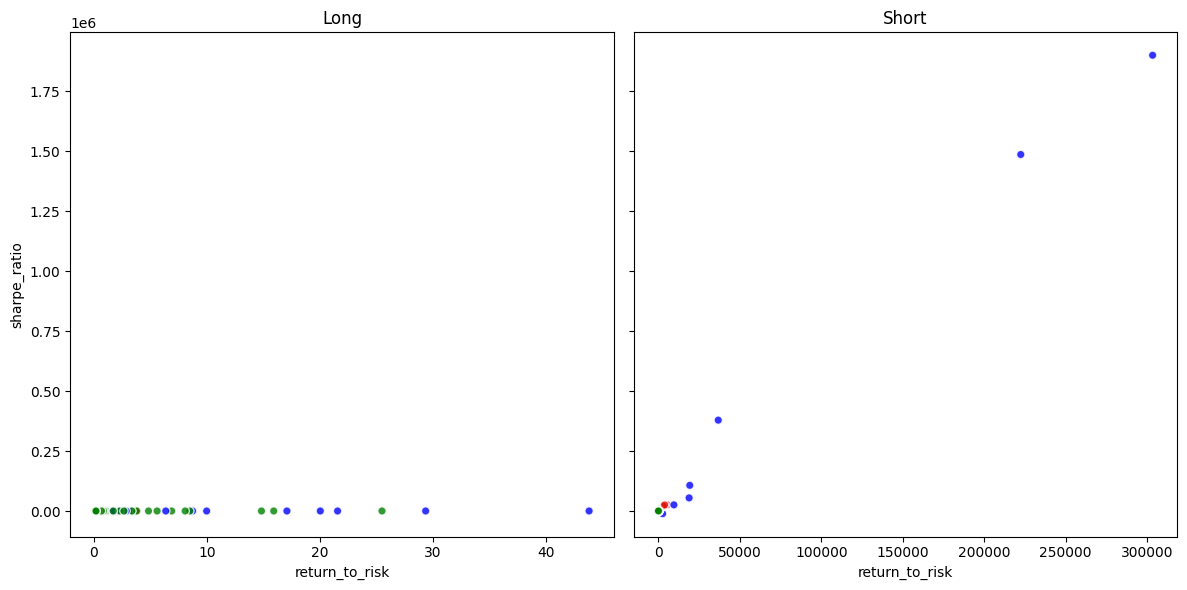

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [77]:
valid = a[(a["position_type"]=="long") & (a["timeframe"]=="week") & (a["selection_type"]!="long_short")].sort_values("pnl",ascending=False).head(20)
valid

,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
862,week,bollinger_upper,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,112.835610,2.574671,43.825259,1.110889,0.885587,0.614000,1.023922,2.454998,<financial_common.portfolio_management.portfol...,blue,2.574671
867,week,obv,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,11.272409,3.951006,2.853048,1.044661,0.961838,0.536000,1.006231,2.112729,<financial_common.portfolio_management.portfol...,blue,3.951006
759,week,bollinger_lower,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,7.750726,3.238053,2.393638,1.059770,0.942697,0.529091,1.004639,1.046957,<financial_common.portfolio_management.portfol...,blue,3.238053
684,week,williams_r,long,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.534631,2.468675,1.836868,1.038631,0.960170,0.520490,1.001008,-0.386560,<financial_common.portfolio_management.portfol...,red,2.468675
653,week,ema,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.085114,2.489487,1.640946,1.042274,0.956826,0.513753,1.000726,-0.706652,<financial_common.portfolio_management.portfol...,blue,2.489487
655,week,bollinger_lower,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3.773359,3.923511,0.961730,1.031818,0.968015,0.530341,1.001852,-1.529881,<financial_common.portfolio_management.portfol...,blue,3.923511
836,week,bollinger_upper,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3.122548,0.367874,8.488085,1.082272,0.915832,0.543000,1.006209,-0.250014,<financial_common.portfolio_management.portfol...,green,0.367874
754,week,rolling_dollar_volume,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.900687,5.592530,0.518672,1.025757,0.974209,0.545273,1.002317,-4.519244,<financial_common.portfolio_management.portfol...,blue,5.592530
677,week,adr,long,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.584428,4.024432,0.642185,1.025641,0.972286,0.545057,1.001367,-4.142522,<financial_common.portfolio_management.portfol...,red,4.024432
650,week,rolling_dollar_volume,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.520054,5.511432,0.457241,1.029149,0.970639,0.530319,1.001668,-5.958863,<financial_common.portfolio_management.portfol...,blue,5.511432


In [76]:
top = valid.head(1).to_dict("records")[0]
top

{'timeframe': 'week',
 'ranking_metric': 'bollinger_upper',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 112.83561035918704,
 'coefficient_of_variation': 2.5746707003480207,
 'portfolio_std': 43.825259029799405,
 'average_gain': 1.1108889405777076,
 'average_loss': 0.8855869999550678,
 'win_loss_ratio': 0.614,
 'weekly_return': 1.0239223914973685,
 'sharpe_ratio': 2.454997906855173,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1e8af9d7890>,
 'color': 'blue',
 'return_to_risk': 2.5746707003480207}

In [69]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [70]:
trades.columns

Index(['year', 'week', 'ticker', 'date', 'adjclose', 'sell_price',
       'asset_class', 'bollinger_upper', 'coefficient_of_variation', 'risk',
       'position_type', 'weight', 'unweighted_return', 'winsorized_return',
       'return', 'name', 'market_cap', 'month', 'quarter'],
      dtype='object')

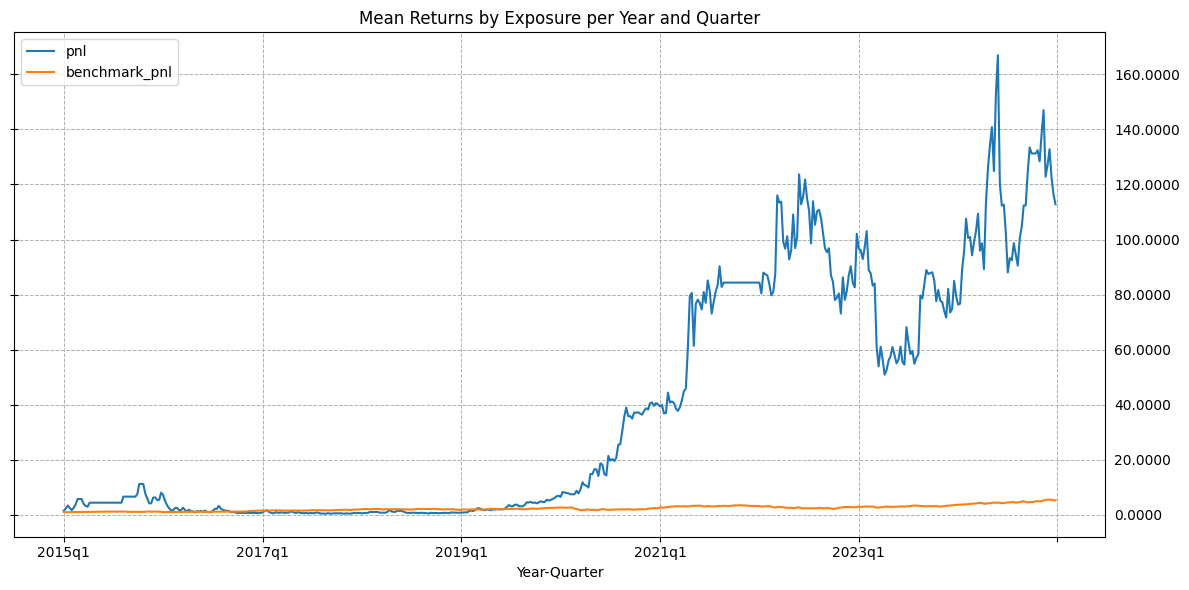

In [71]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [72]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False)

KeyError: "['office'] not in index"

In [73]:
trades.sort_values("return",ascending=False)

,year,week,ticker,date,adjclose,sell_price,asset_class,bollinger_upper,coefficient_of_variation,risk,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
5,2015,15,GMGI,2015-04-10 00:00:00+00:00,6.749963e+05,6.749963e+06,common_stock,36.665714,1.573374,1.573374,1.0,1,1.500000,1.500000,1.500000,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,4,2
42,2015,4,GMGI,2015-01-23 00:00:00+00:00,6.749963e+05,6.749963e+06,common_stock,164.335068,0.404208,0.404208,1.0,1,1.500000,1.500000,1.500000,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,1,1
32,2015,40,LINC,2015-10-02 00:00:00+00:00,1.964000e-01,8.050000e-01,common_stock,13.803281,0.501163,0.501163,1.0,1,1.500000,1.500000,1.500000,Lincoln Educational Services,5.433963e+08,10,4
52,2016,12,GMGI,2016-03-24 00:00:00+00:00,3.374981e+03,6.749963e+03,common_stock,314.098878,1.099257,1.099257,1.0,1,1.500000,1.500000,1.500000,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,3,1
63,2016,23,GMGI,2016-06-10 00:00:00+00:00,4.724998e+01,1.912499e+02,common_stock,2082.142996,2.623467,2.623467,1.0,1,1.500000,1.500000,1.500000,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2016,18,GMGI,2016-05-06 00:00:00+00:00,1.124999e+03,3.172498e+02,common_stock,459.229453,1.571789,1.571789,1.0,1,0.692308,0.692308,0.692308,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,5,2
37,2015,45,VERB,2015-11-06 00:00:00+00:00,2.028000e+04,1.380000e+04,common_stock,47.776007,0.428524,0.428524,1.0,1,0.692308,0.692308,0.692308,"Verb Technology Company, Inc. Common Stock",5.365349e+06,11,4
46,2015,6,ATLX,2015-02-06 00:00:00+00:00,3.000000e+00,2.025000e+00,common_stock,25.597246,0.679463,0.679463,1.0,1,0.692308,0.692308,0.692308,Atlas Lithium Corporation Common Stock,7.787012e+07,2,1
50,2016,10,GMGI,2016-03-11 00:00:00+00:00,6.749963e+03,3.374981e+03,common_stock,295.571277,1.810641,1.810641,1.0,1,0.692308,0.692308,0.692308,"Golden Matrix Group, Inc. Common Stock",2.734203e+08,3,1
